In [1]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import os
import pprint
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

In [2]:
# lstm model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from matplotlib import pyplot
import keras
from tensorflow.keras.layers import GRU
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import BatchNormalization

In [53]:
Final_Normal_Spec = pd.read_csv("1Final_Normal_Spec.csv")
Final_Normal_Spec = Final_Normal_Spec[:70000]
Final_Fuzz_Spec = pd.read_csv("1Final_Fuzz_Spec.csv")
Final_Fuzz_Spec = Final_Fuzz_Spec[:139586]
Final_DoS_Spec = pd.read_csv("1Final_DoS_Spec.csv")
Final_DoS_Spec = Final_DoS_Spec[:100000]
Final_Replay_Spec = pd.read_csv("1Final_Replay_Spec.csv")

Concat = pd.concat([pd.DataFrame(Final_Normal_Spec.values), pd.DataFrame(Final_Fuzz_Spec.values), 
                    pd.DataFrame(Final_DoS_Spec.values), pd.DataFrame(Final_Replay_Spec.values)], 
                   ignore_index=True) 

In [54]:
145172-5586

139586

In [55]:
Final_DoS_Spec.shape

(100000, 259)

In [56]:
Concat.shape

(360000, 259)

In [57]:
Concat = np.array(Concat)

In [58]:
Final = Concat.reshape(-1,1000,Concat.shape[1])
shuffle_idx = np.random.permutation(Final.shape[0])
Final = Final[shuffle_idx]

In [59]:
print('Old:', Final.shape)
Final = Final.reshape(360000, 259)
print('Updated:',Final.shape)

Old: (360, 1000, 259)
Updated: (360000, 259)


In [60]:
X = Final[:, :258]
y = Final[:,258]

In [61]:
#Data normalization by scalling
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X.shape

(360000, 258)

In [62]:
pd.value_counts(y)

1.0    139586
2.0    100000
0.0     70000
3.0     50414
dtype: int64

In [63]:
X_trainX = []
y_trainX = []
strat_time = 0
timestamp = 10
length = len(Final)

for i in range(length):
    X_trainX.append(X[strat_time:timestamp, :258])
    y_trainX.append(y[timestamp])
    
    if timestamp >= 360000-10:
        break
    
    strat_time = strat_time + 1
    timestamp = timestamp + 1
print(len(X_trainX))
print(len(y_trainX))

359981
359981


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_trainX, y_trainX, test_size=0.05, random_state=0)

In [65]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [66]:
X_train.shape

(341981, 10, 258)

In [67]:
pd.value_counts(y_train)

1.0    132572
2.0     94991
0.0     66575
3.0     47843
dtype: int64

In [68]:
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)

In [69]:
print(y_train[0])
print(y_test[64])
print(y_train[2345])
print(y_test[97])

[1. 0. 0. 0.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]
[0. 1. 0. 0.]


In [70]:
X_test.shape

(18000, 10, 258)

In [71]:
print(X_train[0])
print('\n')
print(y_train[0])

[[5.95098939e-09 6.83506153e-08 1.65792627e-07 ... 1.07026016e-01
  4.11161637e-01 4.09675002e-01]
 [7.47300305e-11 5.19913178e-08 1.56341840e-07 ... 1.07670216e-01
  4.10846962e-01 4.09302105e-01]
 [5.32421959e-10 5.06590309e-08 1.53102888e-07 ... 1.08412133e-01
  4.10510626e-01 4.08838092e-01]
 ...
 [4.16605189e-07 1.57862812e-07 1.60508354e-07 ... 1.18221932e-01
  4.09382774e-01 4.03046482e-01]
 [5.57350059e-07 1.97202374e-07 1.69984524e-07 ... 1.21459703e-01
  4.09244870e-01 4.01189452e-01]
 [6.84220248e-07 2.37755226e-07 1.81389246e-07 ... 1.25001102e-01
  4.09187713e-01 3.99215283e-01]]


[1. 0. 0. 0.]


In [22]:
# The GRU architecture
model = Sequential()

model.add(GRU(units=120, return_sequences=True, input_shape=(10, 258), activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GRU(units=120, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GRU(units=120, activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.add(Dense(units = 4, activation='softmax'))
model.compile(optimizer = optimizer, loss = 'CategoricalCrossentropy', metrics=['accuracy'])

In [23]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="Final_GRU.h5",
                               mode='min', monitor='val_loss', verbose=0, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [24]:
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=256,
                    shuffle=False,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/1000
1336/1336 [==============================] - 20s 12ms/step - loss: 0.6258 - accuracy: 0.7133 - val_loss: 0.4802 - val_accuracy: 0.7735
Epoch 2/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.4757 - accuracy: 0.7819 - val_loss: 0.3985 - val_accuracy: 0.8519
Epoch 3/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.3927 - accuracy: 0.8202 - val_loss: 0.3042 - val_accuracy: 0.8665
Epoch 4/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.3342 - accuracy: 0.8447 - val_loss: 0.2984 - val_accuracy: 0.8594
Epoch 5/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.2985 - accuracy: 0.8593 - val_loss: 0.2904 - val_accuracy: 0.8620
Epoch 6/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.2751 - accuracy: 0.8693 - val_loss: 0.2273 - val_accuracy: 0.8876
Epoch 7/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.2555 - accuracy: 0.8779 - val_

1336/1336 [==============================] - 15s 11ms/step - loss: 0.0583 - accuracy: 0.9741 - val_loss: 0.0525 - val_accuracy: 0.9769
Epoch 57/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0578 - accuracy: 0.9739 - val_loss: 0.0617 - val_accuracy: 0.9734
Epoch 58/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0575 - accuracy: 0.9743 - val_loss: 0.0558 - val_accuracy: 0.9752
Epoch 59/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0568 - accuracy: 0.9744 - val_loss: 0.0576 - val_accuracy: 0.9747
Epoch 60/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0559 - accuracy: 0.9746 - val_loss: 0.0497 - val_accuracy: 0.9787
Epoch 61/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0555 - accuracy: 0.9749 - val_loss: 0.0478 - val_accuracy: 0.9785
Epoch 62/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0554 - accuracy: 0.9751 - val_loss: 0

1336/1336 [==============================] - 15s 11ms/step - loss: 0.0397 - accuracy: 0.9817 - val_loss: 0.0525 - val_accuracy: 0.9795
Epoch 112/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0393 - accuracy: 0.9817 - val_loss: 0.0367 - val_accuracy: 0.9848
Epoch 113/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0393 - accuracy: 0.9820 - val_loss: 0.0406 - val_accuracy: 0.9829
Epoch 114/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0392 - accuracy: 0.9820 - val_loss: 0.0351 - val_accuracy: 0.9845
Epoch 115/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0383 - accuracy: 0.9822 - val_loss: 0.0419 - val_accuracy: 0.9828
Epoch 116/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0388 - accuracy: 0.9822 - val_loss: 0.0368 - val_accuracy: 0.9843
Epoch 117/1000
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0382 - accuracy: 0.9825 - val_l

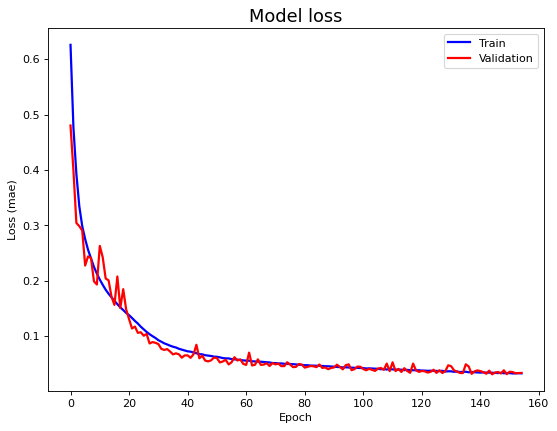

In [25]:
# plot the training losses
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.plot(model.history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(model.history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [26]:
X_test[0].shape

(10, 258)

In [27]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('Final_GRU.h5')

In [72]:
#Prediction
pred = model.predict(X_test)
#obj = scaler.fit(y_pred)
#predicted = obj.inverse_transform(y_pred)

In [73]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(pred, axis=1)
# label
y_test = np.argmax(y_test, axis=1)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[3409    4    1    1]
 [   3 6769  223   19]
 [   1   36 4966    6]
 [   1    8    4 2549]]


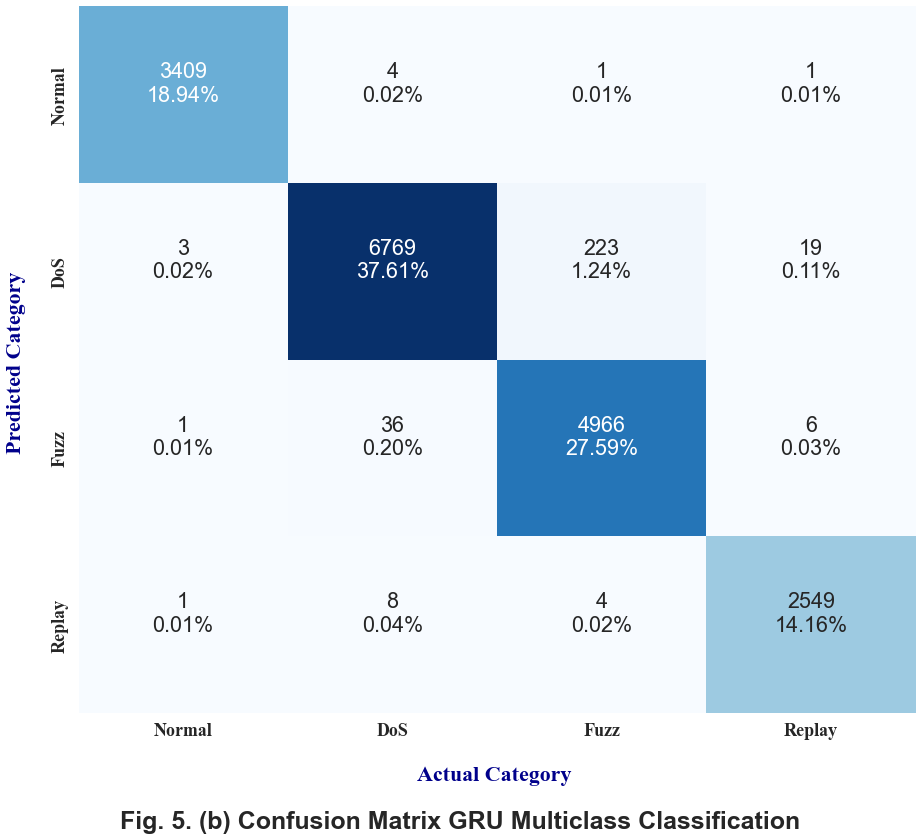

In [95]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)
sns.set(rc={'figure.figsize':(15,13)})
sns.set(font_scale=1.8) #edited as suggested
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)


ax.set_xlabel('\nActual Category ', fontname="Times New Roman", size=22,fontweight="bold")
ax.set_ylabel('Predicted Category \n', fontname="Times New Roman", size=22,fontweight="bold");
ax.text(0.2, 4.65, 'Fig. 5. (b) Confusion Matrix GRU Multiclass Classification',fontsize=25,fontweight="bold")

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"],fontweight="bold", fontname="Times New Roman", size=18)
ax.yaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"],fontweight="bold", fontname="Times New Roman", size=18)
ax.xaxis.label.set_color('darkblue')
ax.yaxis.label.set_color('darkblue')
## Display the visualization of the Confusion Matrix.
plt.show()

In [75]:
from sklearn.metrics import classification_report
class_names = ["Normal", "DoS", "Fuzz", "Replay"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3415
         DoS       0.99      0.97      0.98      7014
        Fuzz       0.96      0.99      0.97      5009
      Replay       0.99      0.99      0.99      2562

    accuracy                           0.98     18000
   macro avg       0.98      0.99      0.99     18000
weighted avg       0.98      0.98      0.98     18000



ROC AUC score: 0.9907134267471338


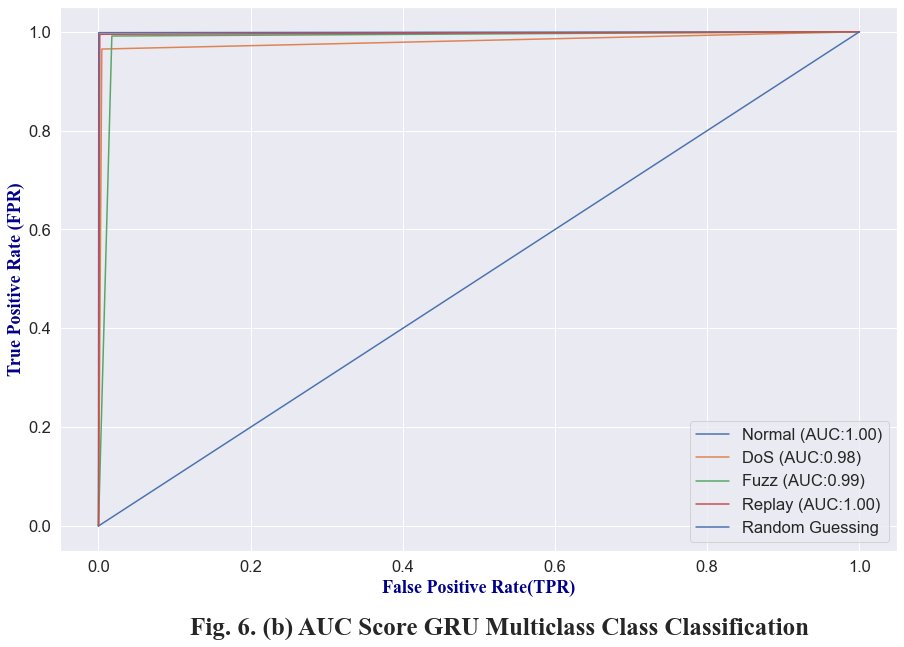

In [77]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ["Normal", "DoS", "Fuzz", "Replay"]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (15, 10))
sns.set(font_scale=1.5) #edited as suggested

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.set_xlabel('False Positive Rate(TPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
c_ax.set_ylabel('True Positive Rate (FPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
c_ax.text(0.12, -0.22, 'Fig. 6. (b) AUC Score GRU Multiclass Class Classification', fontname="Times New Roman",fontsize=25,fontweight="bold")
c_ax.legend(loc="lower right")

In [78]:
Tesla_Normal_Spec = pd.read_csv("Tesla_Normal_Spec.csv")
Tesla_Fuzz_Spec = pd.read_csv("Tesla_Fuzz_Spec.csv")
Tesla_DoS_Spec = pd.read_csv("Tesla_DoS_Spec.csv")
Tesla_Replay_Spec = pd.read_csv("Tesla_Replay_Spec.csv")



tesla = pd.concat([pd.DataFrame(Tesla_Normal_Spec.values), pd.DataFrame(Tesla_Fuzz_Spec.values), 
                    pd.DataFrame(Tesla_DoS_Spec.values), pd.DataFrame(Tesla_Replay_Spec.values)], 
                   ignore_index=True) 
print(tesla.shape)

(4433, 259)


In [79]:
print(Concat.shape)

(360000, 259)


In [80]:
tesla = np.array(tesla)

In [81]:
tesla[:,258]

array([0., 0., 0., ..., 3., 3., 3.])

In [82]:
X = tesla[:, :258]
y = tesla[:,258]

In [83]:
#Data normalization by scalling
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X.shape

(4433, 258)

In [84]:
X_trainX = []
y_trainX = []
strat_time = 0
timestamp = 10
length = len(Final)

for i in range(length):
    X_trainX.append(X[strat_time:timestamp, :258])
    y_trainX.append(y[timestamp])
    
    if timestamp >= 4433-10:
        break
    
    strat_time = strat_time + 1
    timestamp = timestamp + 1
print(len(X_trainX))
print(len(y_trainX))

X_trainXX = np.array(X_trainX)
y_trainXX = np.array(y_trainX)

4414
4414


In [85]:
y_trainXX = to_categorical(y_trainX, 4)

In [87]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model_x = load_model('Final_GRU.h5')

In [88]:
#Prediction
pred_x = model_x.predict(X_trainXX)
#obj = scaler.fit(y_pred)
#predicted = obj.inverse_transform(y_pred)

In [89]:
from sklearn.metrics import confusion_matrix

y_pred_x = np.argmax(pred_x, axis=1)
# label
y_test_x = np.argmax(y_trainXX, axis=1)
#Get the confusion matrix
cf_matrix_x = confusion_matrix(y_test_, y_pred_)

print(cf_matrix_x)

[[1878   11    0    0]
 [  10 1176  323    0]
 [   0  347  147    0]
 [   0  284  238    0]]


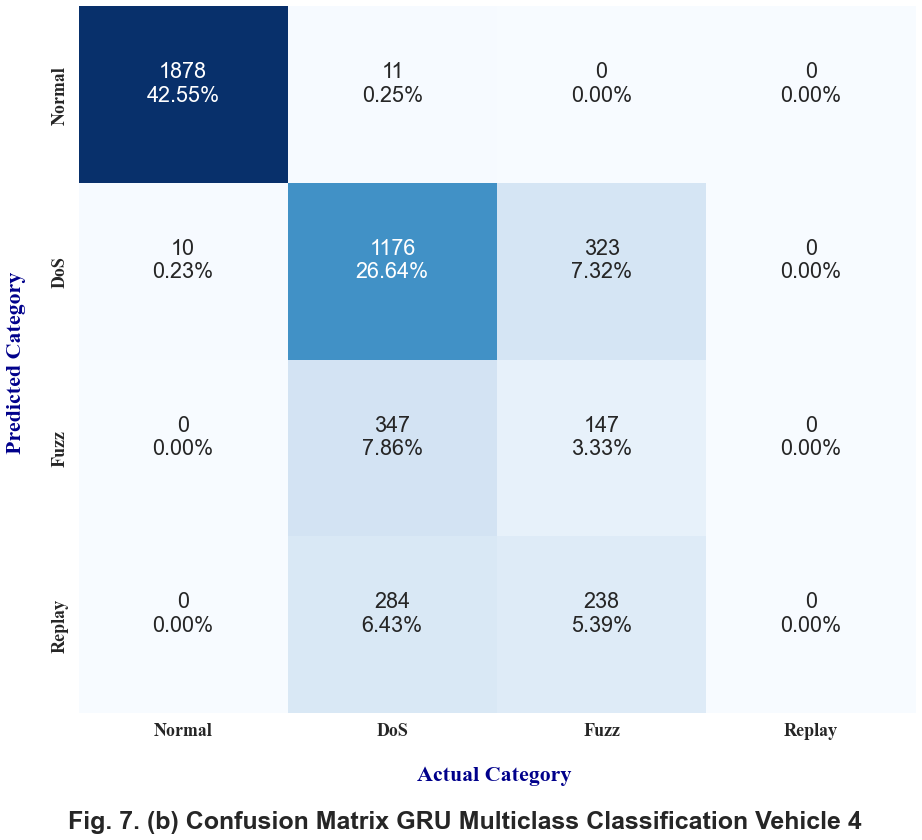

In [90]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_x.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_x.flatten()/np.sum(cf_matrix_x)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)
sns.set(rc={'figure.figsize':(15,13)})
sns.set(font_scale=1.8) #edited as suggested
ax = sns.heatmap(cf_matrix_x, annot=labels, fmt='', cmap='Blues', cbar=False)


ax.set_xlabel('\nActual Category ', fontname="Times New Roman", size=22,fontweight="bold")
ax.set_ylabel('Predicted Category \n', fontname="Times New Roman", size=22,fontweight="bold");
ax.text(-0.05, 4.65, 'Fig. 7. (b) Confusion Matrix GRU Multiclass Classification Vehicle 4',fontsize=25,fontweight="bold")

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"],fontweight="bold", fontname="Times New Roman", size=18)
ax.yaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"],fontweight="bold", fontname="Times New Roman", size=18)
ax.xaxis.label.set_color('darkblue')
ax.yaxis.label.set_color('darkblue')
## Display the visualization of the Confusion Matrix.
plt.show()

In [91]:
from sklearn.metrics import classification_report
class_names = ["Normal", "DoS", "Fuzz", "Replay"]
print(classification_report(y_test_x, y_pred_x, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1889
         DoS       0.65      0.78      0.71      1509
        Fuzz       0.21      0.30      0.24       494
      Replay       0.00      0.00      0.00       522

    accuracy                           0.73      4414
   macro avg       0.46      0.52      0.49      4414
weighted avg       0.67      0.73      0.69      4414



C:\Users\Lisa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lisa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lisa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.7128750999037381


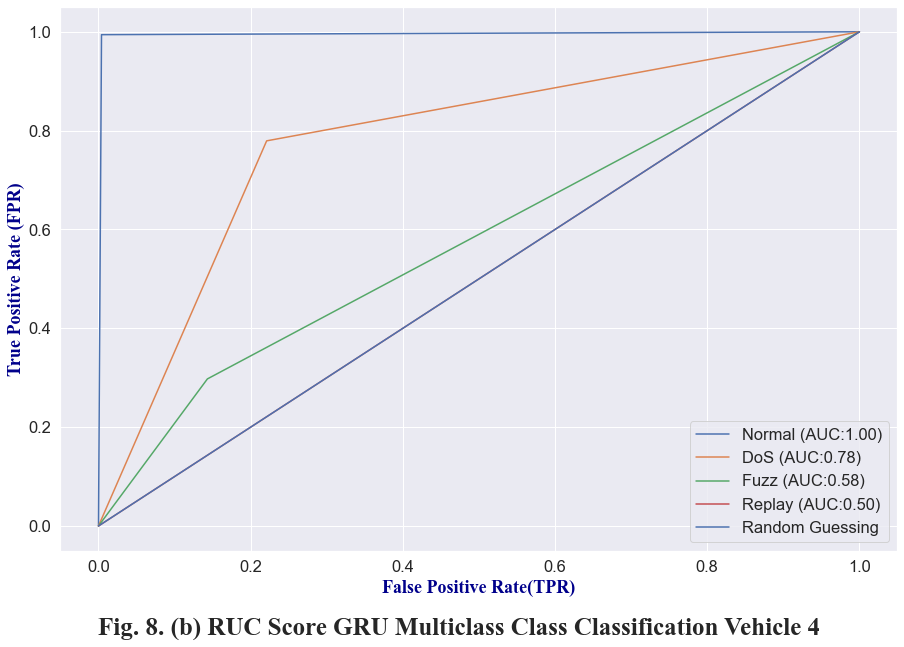

In [94]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ["Normal", "DoS", "Fuzz", "Replay"]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (15, 10))
sns.set(font_scale=1.5) #edited as suggested

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test_x, y_pred_x, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test_x)
    y_test_x = lb.transform(y_test_x)
    y_pred_x = lb.transform(y_pred_x)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test_x[:,idx].astype(int), y_pred_x[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test_x, y_pred_x, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test_x, y_pred_x))

c_ax.set_xlabel('False Positive Rate(TPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
c_ax.set_ylabel('True Positive Rate (FPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
c_ax.text(0.00, -0.22, 'Fig. 8. (b) RUC Score GRU Multiclass Class Classification Vehicle 4', fontname="Times New Roman",fontsize=25,fontweight="bold")
c_ax.legend(loc="lower right")